In [1]:
#exercise my notebook interface where i instatiate some of the gratbot brain to process old data
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210314-114641.txt")                                                


In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np

class Plotter(Gyrus):
    def __init__(self,vname,title,ylabel):
        self.value_name=vname
        self.dataseries=TimeSeries(title=title,ylabel=ylabel)
        
    
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            self.dataseries.append(message["timestamp"],message[self.value_name])
        return []
    
class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))

        return []

In [3]:
from PoseTrackerGyrus import PoseTrackerGyrus
from MotionGyrus import MotionEstimationGyrus

plotters={}
plotters["compass_heading"]=Plotter("compass_heading","Compass Heading","Degrees")
plotters["pose"]=PosePlotter()


gyrii=[]
gyrii.append(PoseTrackerGyrus())
motionestimationgyrus=MotionEstimationGyrus()
gyrii.append(motionestimationgyrus)

for key in plotters:
    gyrii.append(plotters[key])
    
    
#Load existing config file into the gyrii
config_filename="../gyrus_config.yaml"
try:
    with open(config_filename,'r') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
        for g in gyrii:
            g.load_config(data)
        f.close()
except:
    print("Unable to load gyrus config file")

#inspect_messagename="timestamp"
inspect_messagename="none"
remove_messages=[]
start_timestamp=sensor_log[0]["timestamp"]
for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                        
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            waiting_messages.extend(g.read_message(on_message))
        
#for key in plotters:
#    plotters[key].dataseries.times=plotters[key].dataseries.times-start_timestamp

n teachable moments 3
n teachable moments 4
n teachable moments 4
n teachable moments 4


C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


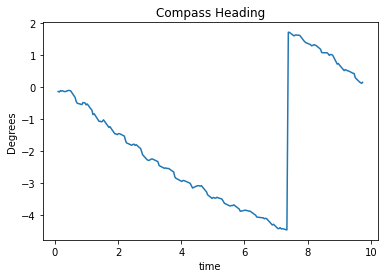

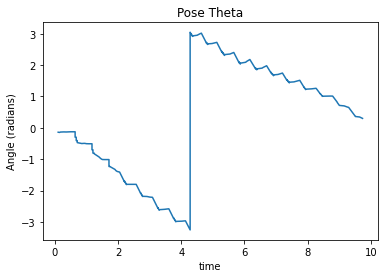

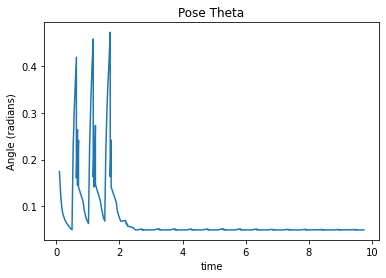

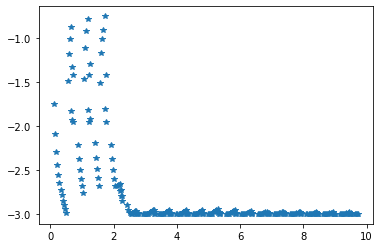

<ipython-input-4-947fdff543c5>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


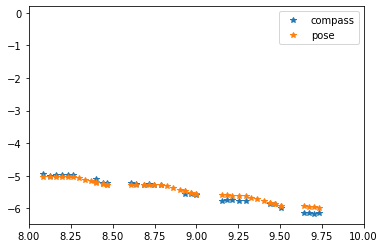

In [4]:
from matplotlib import pyplot as plt
import numpy as np

def unwrap_angle(data_array):
    ret=[data_array[0]]
    for i in range(1,len(data_array)):
        if data_array[i]-ret[-1]>np.pi:
            ret.append(data_array[i]-2*np.pi)
        elif data_array[i]-ret[-1]<-np.pi:
            ret.append(data_array[i]+2*np.pi)
        else:
            ret.append(data_array[i])
    return ret


plotters["compass_heading"].dataseries.plot()
#plotters["pose"].x_dataseries.plot()

#plotters["pose"].y_dataseries.plot()
plotters["pose"].theta_dataseries.plot()
plotters["pose"].theta_unc_dataseries.plot()
fig, ax = plt.subplots()
ax.plot(plotters["pose"].theta_unc_dataseries.times,np.log(plotters["pose"].theta_unc_dataseries.data),'*')
plt.show()

fig, ax = plt.subplots()
#plt.xlim(2,4)
#plt.xlim(6,8)
plt.xlim(8,10)
ax.plot(plotters["compass_heading"].dataseries.times,unwrap_angle(plotters["compass_heading"].dataseries.data),'*',label="compass")
ax.plot(plotters["pose"].theta_dataseries.times,unwrap_angle(plotters["pose"].theta_dataseries.data),'*',label="pose")
plt.legend()

fig.show()


In [5]:
#print(motionestimationgyrus.turn_record)
    
def plot_turn_record(me):    
    
    tmags=[]
    dpos=[]
    dt=[]
    unc=[]
    
    for elem in me.turn_record:
        dt.append(elem[1])
        dpos.append(elem[0][2])
        tmags.append(elem[2][2]*elem[1])
        unc.append(np.sqrt(elem[3][2][2]))    
    fig, ax = plt.subplots()
    plt.plot(np.arange(len(dpos)),dpos,'*')
    #plot.errorbars()
    plt.show()
    
    
    fig, ax = plt.subplots()
    #plt.plot(tmags,dpos,'*')
    plt.errorbar(tmags,dpos,yerr=unc)
        
    plt.show()
    
def fit_records_to_slope(records,dim):
    #given motion records and a single dimension, fit to y=m*x
    #returns best fit m, m_unc, chi-square/n
    xxsum=0
    xysum=0
    yysum=0
    
    for elem in records:
        x=elem[dim][dim]*elem[1]
        y=elem[0][dim]
        sigmasquare=elem[3][dim][dim]
        xxsum+=x*x/sigmasquare
        xysum+=x*y/sigmasquare
        yysum+=y*y/sigmasquare
    myslope=xysum/xxsum
    myslope_unc=np.sqrt(sigmasquare/xxsum)
    chisq=myslope*myslope*xxsum-2*myslope*xysum+yysum
    chisq=chisq/len(records)
    if chisq>1: #inflate uncertainties if I'm underestimating error bars on data
        myslope_unc*=np.sqrt(chisq)
    return myslope,myslope_unc,chisq

    
    
    
#plot_turn_record(motionestimationgyrus)
#fit_records_to_slope(motionestimationgyrus.turn_record,2)
    

In [6]:
#save the results

#Load existing config file into the gyrii
config_object={}
for g in gyrii:
    config_object.update(g.save_config())

config_filename="../gyrus_config.yaml"

with open(config_filename,'w') as f:
        data = yaml.dump(config_object,f)                
        f.close()